# Databricks ML Workflow
In this notebook I explore a Machine Learning workflow on Databricks. A Databricks 13.3 ML runtime has been used to run this notebook.
The Machine Learning workflow demonstrated includes the loading and exploration of the Combined Cycle Power Plant dataset. A Linear Regression model is trained on the dataset using Hyperopt to search for the optimal hyperparameters. The model predictions on the validation set are visualised. A Gradient Boosting Regressor is trained and compared to the Linear Regression model. Again, Hyperopt is used to optimise the hyperparameters. Finally, the best model is trained on the full training data and evaluated on the test set. MLflow is used throughout the notebook to track the experiments.

### Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import mlflow
from hyperopt import fmin, tpe, hp, SparkTrials

## Powerplant data

I will be using the Combined Cycle Power Plant dataset.
The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP)  of the plant.
<br>
Tfekci,Pnar and Kaya,Heysem. (2014). Combined Cycle Power Plant. UCI Machine Learning Repository. https://doi.org/10.24432/C5002N.
<br>Additional information can be found [here](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant).

In [ ]:
powerplant_df = (sqlContext.read
                 .format("com.databricks.spark.csv")
                 .option("header", "true")
                 .option("inferSchema", "true")
                 .option("delimiter", "\t")
                 .load("/databricks-datasets/power-plant/data"))

powerplant_df = powerplant_df.toPandas()

In [ ]:
powerplant_df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


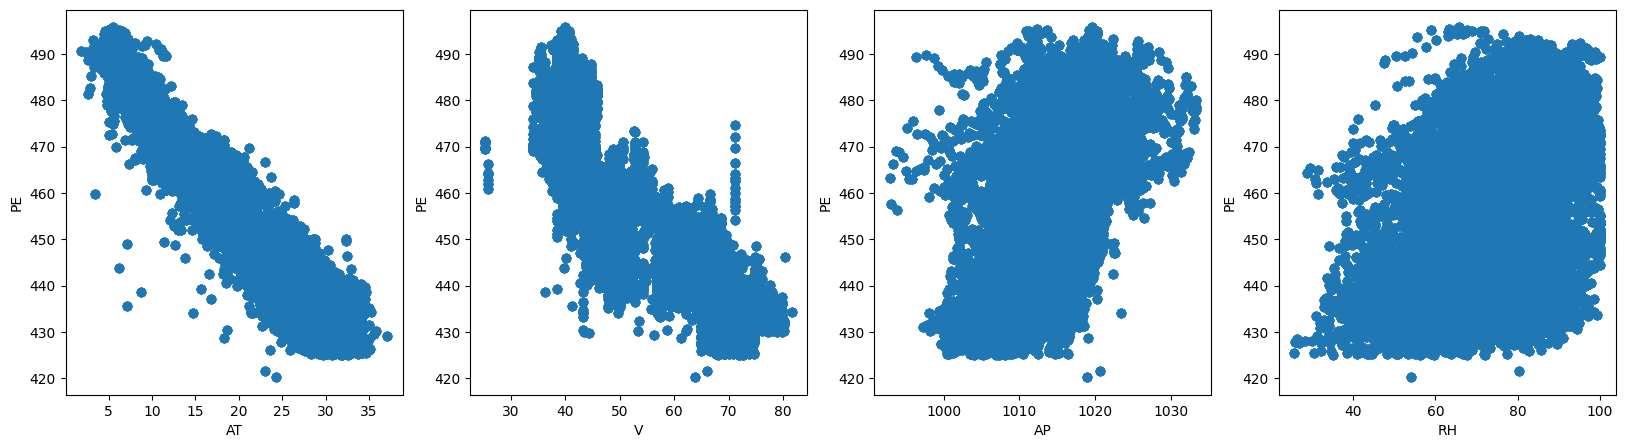

In [ ]:
# Plotting
f, axes = plt.subplots(1, 4, figsize=(20, 5))
for idx, col in enumerate(powerplant_df.columns[:-1]):
    axes[idx].scatter(powerplant_df[col], powerplant_df['PE'])
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('PE')

There seem to be no noteworthy outliers in the dataset. The temperature (AT) feature springs out, showing a significant correlation with the power output.

In [ ]:
powerplant_df.isna().any()

AT    False
V     False
AP    False
RH    False
PE    False
dtype: bool

There is no missing data

### Prepare data for training

In [ ]:
# PE will be our label
x = powerplant_df.drop(["PE"], axis=1)
y = powerplant_df.PE

# Splitting the data into training, validation and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.75)

## Train Linear (Ridge) Regression model

Let us train a Linear Ridge Regression model on polynomial features. I will use Hyperopt to optimise the hyperpamameters alpha and the polynomial degree. I will use MLflow to track the experiment.

In [ ]:
# Model training and evaluating function
def train_model(params):
    mlflow.sklearn.autolog()
    with mlflow.start_run(nested=True):
        model = Pipeline([
            ('polynomial_features', PolynomialFeatures(degree=params['degree'], include_bias=False)),
            ('ridge_regression', Ridge(params['alpha']))])
        model.fit(x_train, y_train)
        mse = mean_squared_error(y_val, model.predict(x_val))

    return mse

# Define hyperparameter search space
search_space = {'alpha': hp.uniform('alpha', 0, 4),
                'degree': hp.randint('degree', 2, 6)}

# Start hyperparameter search
with mlflow.start_run(run_name="linear_regression") as run:
    best_params = fmin(
        fn=train_model,
        space=search_space,
        algo=tpe.suggest,
        max_evals=128,
        trials=SparkTrials(parallelism=2))

# Save run id
lr_run_id = run.info.run_id

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


100%|██████████| 128/128 [13:33<00:00,  6.35s/trial, best loss: 15.554563538528019]


Total Trials: 128: 128 succeeded, 0 failed, 0 cancelled.


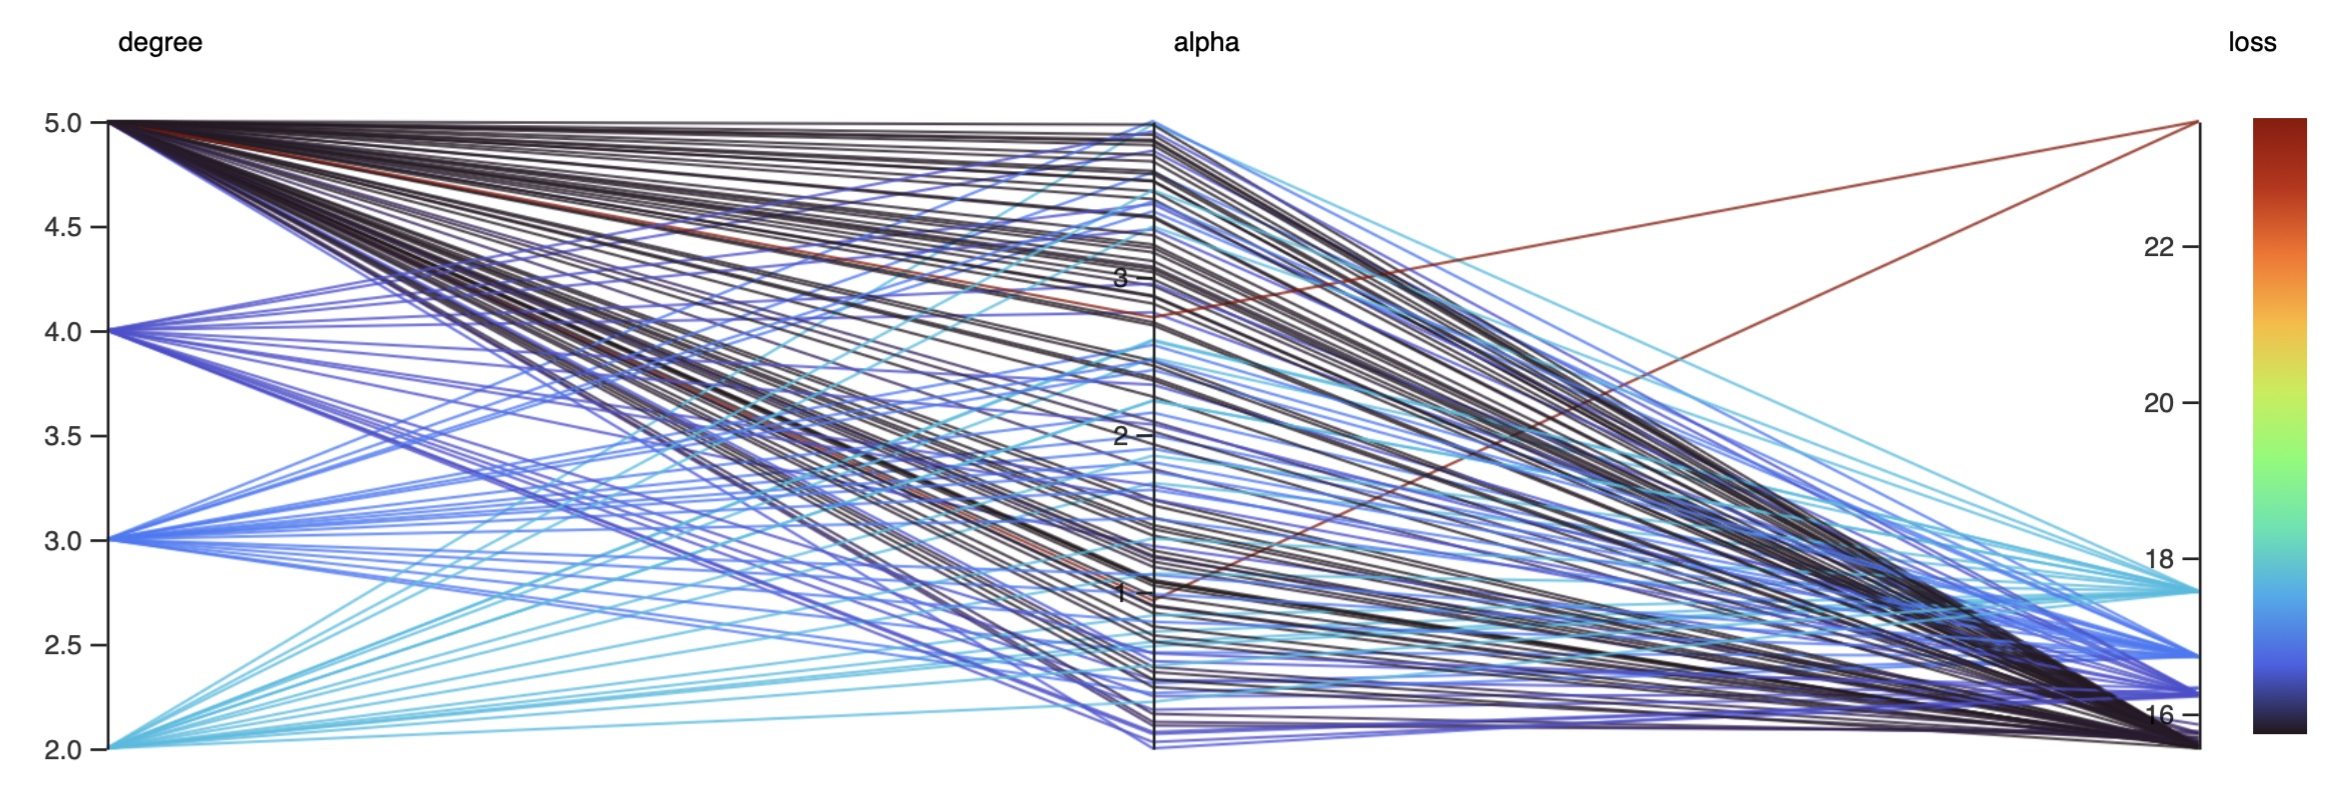

### Show predictions
Let us visualise the model predictions

In [ ]:
# Retrieve the best run
runs = mlflow.search_runs(filter_string=f"tags.mlflow.parentRunId = '{lr_run_id}'")
best_run = runs.sort_values(by=['metrics.loss']).iloc[0]
print(f"Best Linear Regression run had a validation MSE of {round(best_run['metrics.loss'], 2)}")
model = mlflow.sklearn.load_model(f'runs:/{best_run.run_id}/model')

Best Linear Regression run had a validation MSE of 15.55


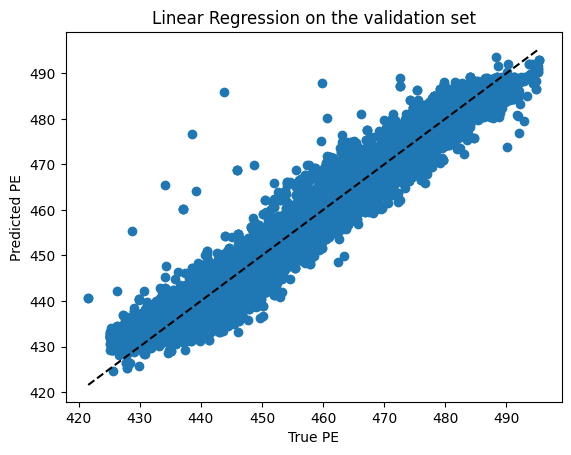

In [ ]:
# Plotting
plt.scatter(y_val, model.predict(x_val))
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='black', linestyle='--')
plt.title("Linear Regression on the validation set")
plt.xlabel('True PE')
plt.ylabel('Predicted PE')
plt.show()

The Linear Regression model is doing allright. There are some outliers where the predicted PE is significantly higher than the true PE.

## Gradient Boosting Regression model

Let us train a Gradient Boosting Regression model and compare it to the Linear Regression model. I will again use Hyperopt to optimise the hyperpamameters and use MLflow to track the experiment. ChatGPT provided the five most impactfull hyperparameters for Gradient Boosting Regression.

In [ ]:
# Model training and evaluating function
def train_model(params):
    mlflow.sklearn.autolog()
    with mlflow.start_run(nested=True):
        model = GradientBoostingRegressor(**params)
        model.fit(x_train, y_train)
        mse = mean_squared_error(y_val, model.predict(x_val))

    return mse

# Define hyperparameter search space
search_space = {
    'n_estimators': hp.randint('n_estimators', 80, 300),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'max_depth': hp.randint('max_depth', 3, 10),
    'min_samples_split': hp.randint('min_samples_split', 2, 9),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 8),
}

# Start hyperparameter search
with mlflow.start_run(run_name="gradient_boosting_regression") as run:
    best_params = fmin(
        fn=train_model,
        space=search_space,
        algo=tpe.suggest,
        max_evals=128,
        trials=SparkTrials(parallelism=2))

# Save run id
gbr_run_id = run.info.run_id

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


100%|██████████| 128/128 [33:46<00:00, 15.83s/trial, best loss: 0.2629465957014792]


Total Trials: 128: 128 succeeded, 0 failed, 0 cancelled.


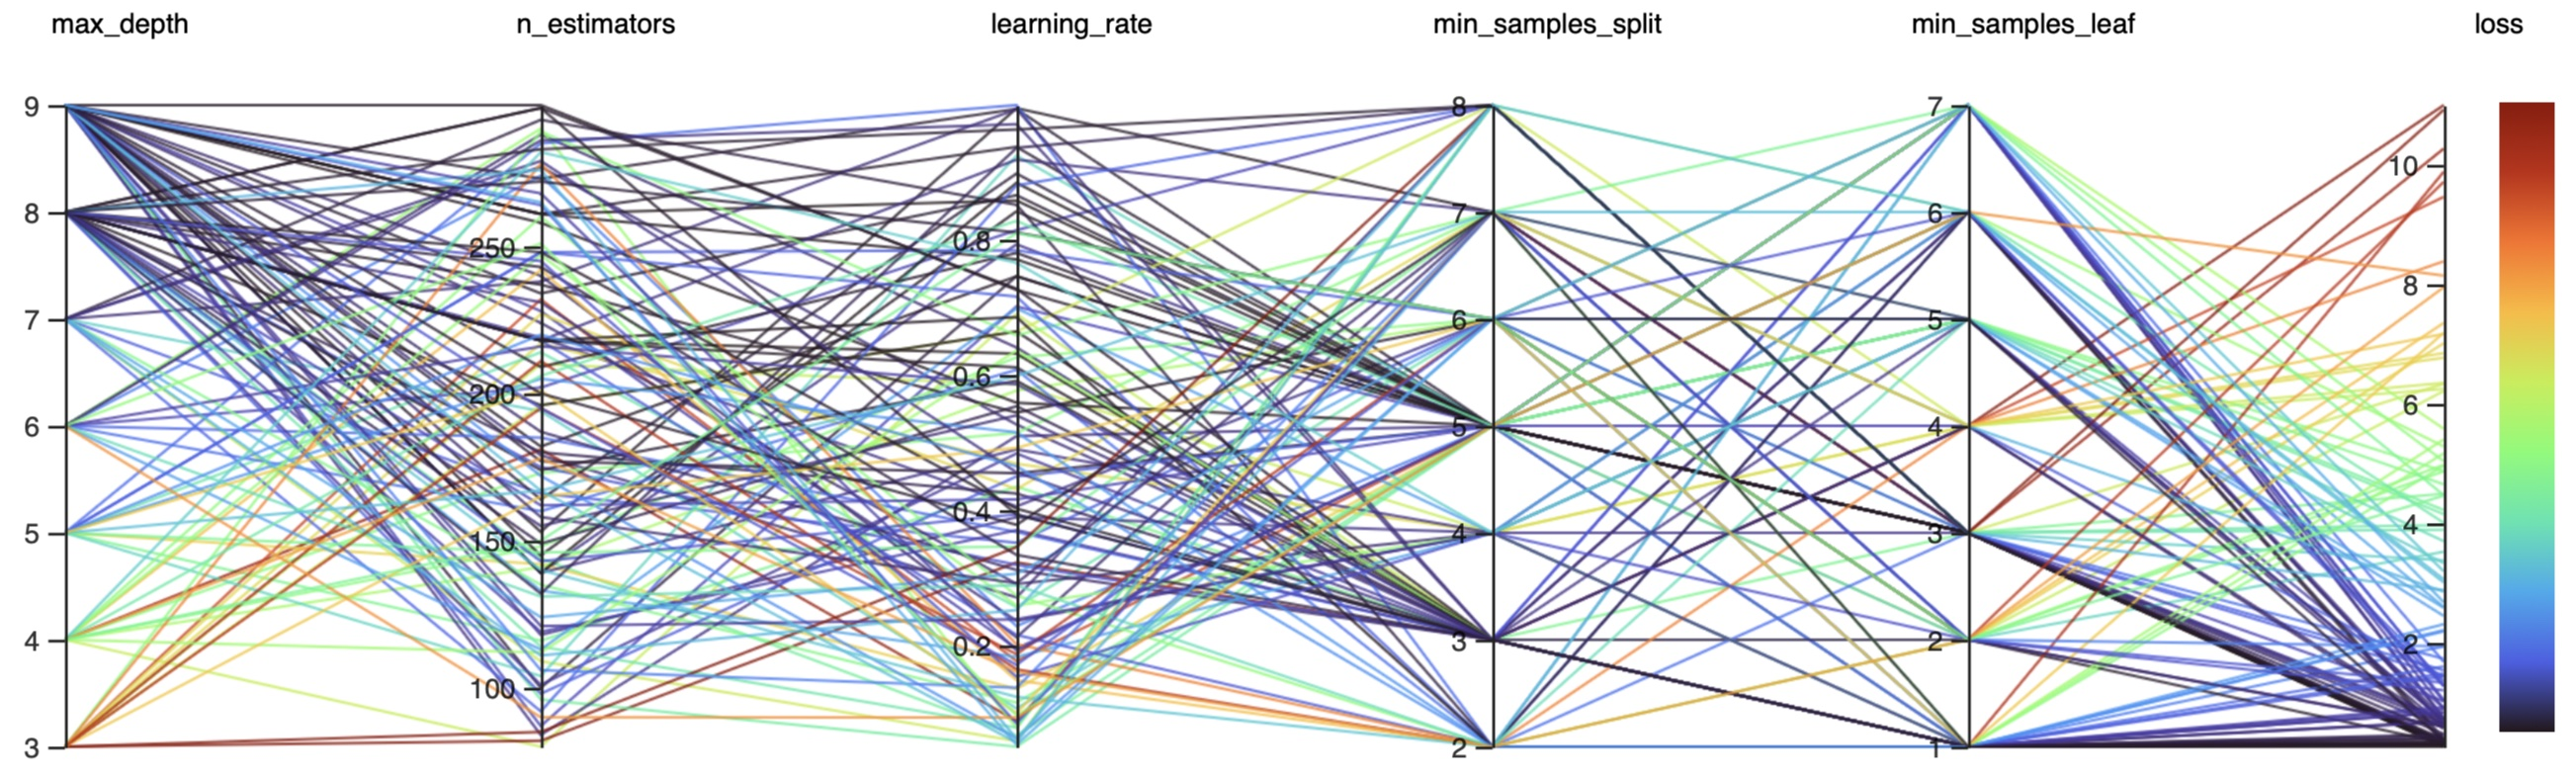

### Show predictions
Let us visualise the model predictions

In [ ]:
# Retrieve the best run
runs = mlflow.search_runs(filter_string=f"tags.mlflow.parentRunId = '{gbr_run_id}'")
best_run = runs.sort_values(by=['metrics.loss']).iloc[0]
print(f"Best Gradient Boosting Regression run had a validation MSE of {round(best_run['metrics.loss'], 2)}")
model = mlflow.sklearn.load_model(f'runs:/{best_run.run_id}/model')

Best Gradient Boosting Regression run had a validation MSE of 0.26


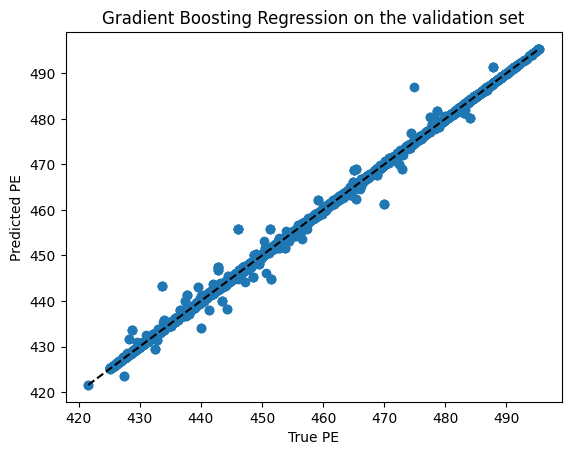

In [ ]:
# Plotting
plt.scatter(y_val, model.predict(x_val))
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='black', linestyle='--')
plt.title("Gradient Boosting Regression on the validation set")
plt.xlabel('True PE')
plt.ylabel('Predicted PE')
plt.show()

Most datapoints are predicted very accurately, with a number of outliers scattered around. But a lot better than the Linear Regression model.

## Final training run

I will proceed with the Gradient Boosting Regression model as it obtained a lower MSE on the validation set. Let us do a final training run on the full training data.

In [ ]:
# Restore full training data
x_train_full = pd.concat([x_train, x_val])
y_train_full = pd.concat([y_train, y_val])

### Train Gradient Boosting Regression model on full dataset

In [ ]:
# Retrieve hyperparameters of the best run
runs = mlflow.search_runs(filter_string=f"tags.mlflow.parentRunId = '{gbr_run_id}'")
best_run = runs.sort_values(by=['metrics.loss']).iloc[0]
best_params = {
    'n_estimators': int(best_run['params.n_estimators']),
    'learning_rate': float(best_run['params.learning_rate']),
    'max_depth': int(best_run['params.max_depth']),
    'min_samples_split': int(best_run['params.min_samples_split']),
    'min_samples_leaf': int(best_run['params.min_samples_leaf']),
}

# Initialise the model
model = GradientBoostingRegressor(**best_params)

In [ ]:
# Train on the full training data
with mlflow.start_run(run_name="gradient_boosting_regression_full") as run:
    mlflow.sklearn.autolog()
    model.fit(x_train_full, y_train_full)

### Evaluate model
Now we can evaluate the final model on the test set

In [ ]:
print(f"The final Gradient Boosting Regresser achieves a MSE of {round(mean_squared_error(y_test, model.predict(x_test)), 2)} on the test set")

The final Gradient Boosting Regresser achieves a MSE of 0.03 on the test set


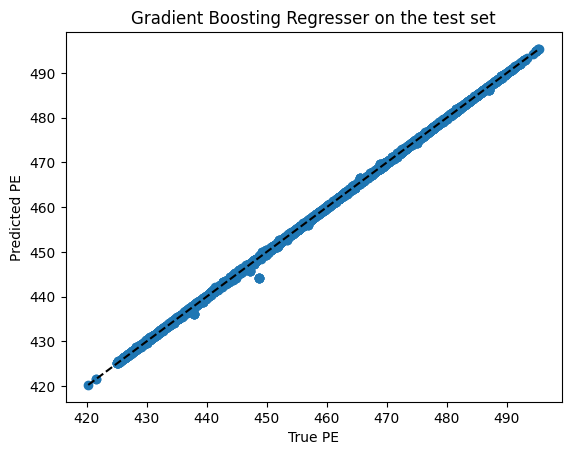

In [ ]:
# Plotting
plt.scatter(y_test, model.predict(x_test))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.title("Gradient Boosting Regresser on the test set")
plt.xlabel('True PE')
plt.ylabel('Predicted PE')
plt.show()

The Gradient Boosting Regresser is doing great on the test set! The MSE is just 0.03.